In [27]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from torch.utils.tensorboard import SummaryWriter

### Read data

In [28]:
df = pd.read_csv('data.csv')
df

,text
0,"Избрав цель, иди к ней всем сердцем."
1,"Боритесь со злом внутри вас, а не со злом внут..."
2,Самые веселые люди - в тоже время и самые мрач...
3,"Во всем есть красота, но не каждый ее видит."
4,"Перед тем как мстить, вырой две могилы."
...,...
2123,Техническая экспансия человечества является су...
2124,Неврозы являются карикатурами на великие социа...
2125,Как раз сегодня моей умершей дочери исполнилос...
2126,"Обычно враждебные чувства появляются позже, че..."


### Preprocessing data

In [29]:
def preprocess(string: str) -> str:
    string = re.sub(r'[^\w]', ' ', string).lower()
    string = re.sub(r'\s+', ' ', string).strip()
    return string

In [30]:
df['text'] = df['text'].apply(preprocess)

In [31]:
df['length'] = df['text'].apply(len)

In [32]:
df.head(10)

,text,length
0,избрав цель иди к ней всем сердцем,34
1,боритесь со злом внутри вас а не со злом внутр...,54
2,самые веселые люди в тоже время и самые мрачные,47
3,во всем есть красота но не каждый ее видит,42
4,перед тем как мстить вырой две могилы,37
5,живи так как хочешь ты а не как ожидают от теб...,150
6,нервно думая о будущем люди забывают о настоящ...,185
7,есть три ошибки в общении людей первая это жел...,173
8,если вы самый умный человек в комнате то вы не...,82
9,в древности люди учились для того чтобы соверш...,104


In [33]:
TEXTS = df['text'].values
LENGTHS = df['length'].values

In [34]:
# Normalize
LENGTHS = (LENGTHS - np.mean(LENGTHS)) / np.std(LENGTHS)

#### Split data

In [35]:
train_texts, test_texts, train_lengths, test_lengths = train_test_split(TEXTS, LENGTHS, test_size=0.2, random_state=42)

#### Vocab and indeces creation

In [36]:
vocab = set(' '.join(TEXTS).split())
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

In [37]:
def text_to_indices(texts, word2idx):
    return [[word2idx[word] for word in text.split()] for text in texts]

train_indices = text_to_indices(train_texts, word2idx)
test_indices = text_to_indices(test_texts, word2idx)

#### Init dataset

In [38]:
class TextDataset(Dataset):
    def __init__(self, texts, lengths):
        self.texts = texts
        self.lengths = lengths

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.lengths[idx], dtype=torch.float)

In [39]:
train_dataset = TextDataset(train_indices, train_lengths)
test_dataset = TextDataset(test_indices, test_lengths)

#### Pad data and init our model

In [40]:
def collate_fn(batch):
    texts, lengths = zip(*batch)
    max_len = max(len(text) for text in texts)
    padded_texts = [torch.cat([text, torch.zeros(max_len - len(text), dtype=torch.long)]) for text in texts]
    return torch.stack(padded_texts), torch.tensor(lengths, dtype=torch.float)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [52]:
class TextRegression(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob=0.05):
        super(TextRegression, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear1 = nn.Linear(hidden_dim, 128)
        self.linear2 = nn.Linear(128, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.dropout(lstm_out)
        linear1_out = self.linear1(lstm_out)
        output = self.linear2(linear1_out)
        return output, linear1_out

In [53]:
model = TextRegression(len(vocab), 128, 128, 1, 0.05)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train model

In [54]:
def trainModel(model, train_loader, test_loader, criterion, optimizer, num_epochs, writer):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for texts, lengths in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(texts)
            loss = criterion(outputs.squeeze(), lengths)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar('Loss/train', train_loss, epoch)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for texts, lengths in test_loader:
                outputs, _ = model(texts)
                loss = criterion(outputs.squeeze(), lengths)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        writer.add_scalar('Loss/test', test_loss, epoch)

        print(f'Epoch {epoch+1}')
        print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

In [55]:
trainModel(model, train_loader, test_loader, criterion, optimizer, 10, writer)

Epoch 1
Train Loss: 1.0506425963507757, Test Loss: 0.4035182052424976
Epoch 2
Train Loss: 1.1040642200796693, Test Loss: 0.2840561025909015
Epoch 3
Train Loss: 0.6359174363315105, Test Loss: 0.21257395004587515
Epoch 4
Train Loss: 0.4160480844201865, Test Loss: 0.16055161053580896
Epoch 5
Train Loss: 0.3767908966789643, Test Loss: 0.2202922020639692
Epoch 6
Train Loss: 0.2856019655311549, Test Loss: 0.18561453265803202
Epoch 7
Train Loss: 0.33847146501971614, Test Loss: 0.1754744007651295
Epoch 8
Train Loss: 0.27553693556951153, Test Loss: 0.16546830029359885
Epoch 9
Train Loss: 0.22682742443349627, Test Loss: 0.14383469681654656
Epoch 10
Train Loss: 0.18742488483311953, Test Loss: 0.1645425089768001


In [47]:
writer.close()

In [56]:
model.eval()
train_preds = []
train_true = []
test_preds = []
test_true = []
train_embeddings = []
test_embeddings = []

with torch.no_grad():
    for texts, lengths in train_loader:
        outputs, embeddings = model(texts)
        train_preds.extend(outputs.squeeze().tolist())
        train_true.extend(lengths.tolist())
        train_embeddings.extend(embeddings.tolist())

    for texts, lengths in test_loader:
        outputs, embeddings = model(texts)
        test_preds.extend(outputs.squeeze().tolist())
        test_true.extend(lengths.tolist())
        test_embeddings.extend(embeddings.tolist())

train_mse = mean_squared_error(train_true, train_preds)
test_mse = mean_squared_error(test_true, test_preds)

print(f'Train MSE: {train_mse}, Test MSE: {test_mse}')

Train MSE: 0.13966266055620008, Test MSE: 0.16110175060618123


#### Visualize my model output

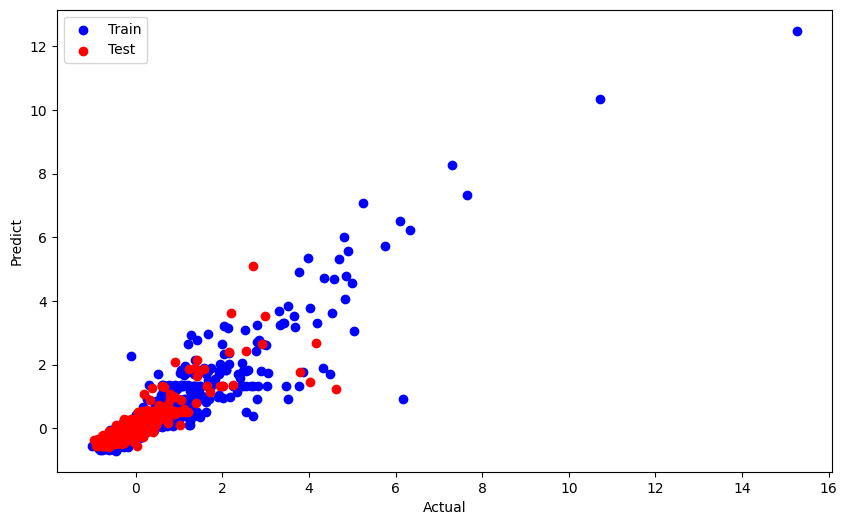

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(train_true, train_preds, c='blue', label='Train')
plt.scatter(test_true, test_preds, c='red', label='Test')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.legend()
plt.show()

#### Embedding creation and visualisation

In [59]:
train_embeddings = np.array(train_embeddings)
test_embeddings = np.array(test_embeddings)

In [60]:
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

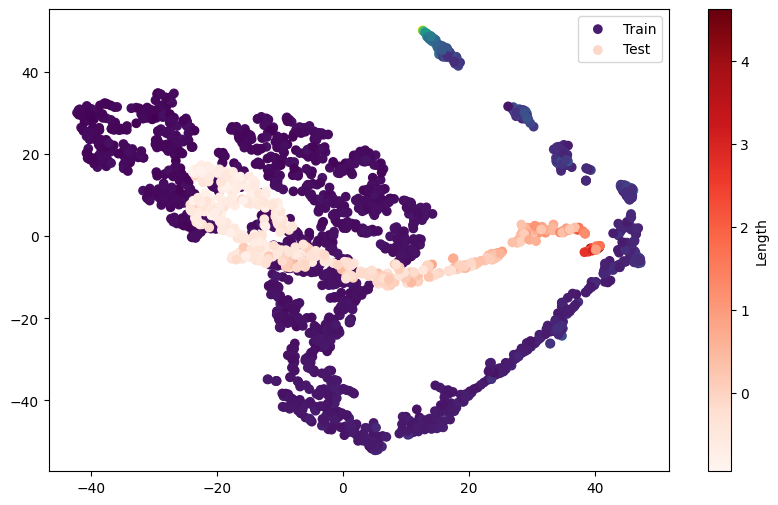

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c=train_true, cmap='viridis', label='Train')
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_true, cmap='Reds', label='Test')
plt.colorbar(label='Length')
plt.legend()
plt.show()

#### Tensorboard metrics

In [69]:
logs = 'runs/Jan10_01-16-15_DESKTOP-O5PJ8QM'

In [81]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def readLogs(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    train_loss = event_acc.Scalars('Loss/train')
    test_loss = event_acc.Scalars('Loss/test')

    train_loss_values = [event.value for event in train_loss]
    test_loss_values = [event.value for event in test_loss]

    return train_loss_values, test_loss_values

In [82]:
train_loss_values, test_loss_values = readLogs(logs)

In [84]:
train_loss_values

[0.3673430383205414,
 0.3750952184200287,
 0.2609819173812866,
 0.2880956530570984,
 0.28144368529319763,
 0.24963578581809998,
 0.23629416525363922,
 0.251223623752594,
 0.2215358465909958,
 0.20796799659729004,
 1.0506426095962524,
 1.1040642261505127,
 0.6359174251556396,
 0.4160480797290802,
 0.3767909109592438,
 0.28560197353363037,
 0.3384714722633362,
 0.2755369246006012,
 0.22682742774486542,
 0.18742488324642181]

In [85]:
test_loss_values

[0.2757258415222168,
 0.2063722014427185,
 0.1947091668844223,
 0.23414573073387146,
 0.17546474933624268,
 0.19187024235725403,
 0.18910153210163116,
 0.20217816531658173,
 0.20610012114048004,
 0.25727376341819763,
 0.4035181999206543,
 0.2840560972690582,
 0.21257394552230835,
 0.16055160760879517,
 0.22029219567775726,
 0.18561452627182007,
 0.1754744052886963,
 0.16546830534934998,
 0.1438346952199936,
 0.16454251110553741]